# NBA Playoff Prediction - Logistic Regression

This notebook implements logistic regression with regularization for predicting NBA playoff qualification.


In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')


In [263]:
# Load processed data
X_train = np.load('data/processed/X_train_scaled.npy')
X_val = np.load('data/processed/X_val_scaled.npy')
X_test = np.load('data/processed/X_test_scaled.npy')

y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")


Training set: X=(446, 32), y=(446,)
Validation set: X=(120, 32), y=(120,)
Test set: X=(120, 32), y=(120,)


In [264]:
# Augment X with column of ones for bias term
def augment_X(X):
    ones = np.ones((X.shape[0], 1))
    return np.hstack([ones, X])

X_train_aug = augment_X(X_train)
X_val_aug = augment_X(X_val)
X_test_aug = augment_X(X_test)

# Reshape y to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Augmented shapes: X_train={X_train_aug.shape}, y_train={y_train.shape}")


Augmented shapes: X_train=(446, 33), y_train=(446, 1)


## Custom Logistic Regression Functions


In [265]:
# 1. Sigmoid function
def sigmoid(z):
    e_term = np.exp(-z)
    return 1/(1+e_term)


In [266]:
# 2. Hypothesis function
def hypothesis(X, w):
    Xw = np.dot(X, w)
    return sigmoid(Xw)


In [267]:
# 3. Log-likelihood function with regularization
def log_likelihood(X, y, w, lambda_reg=0):
    hyp = hypothesis(X, w)
    log_lik = np.sum(y * np.log(hyp + 1e-10) + (1 - y) * np.log(1 - hyp + 1e-10))
    
    # Add L2 regularization term (excluding bias term)
    if lambda_reg > 0:
        w_without_bias = w[1:].copy()  # Exclude bias term
        reg_term = -lambda_reg * np.sum(w_without_bias ** 2) / 2
        log_lik += reg_term
    
    return log_lik


In [268]:
# 4. Gradient Ascent function with regularization
def Gradient_Ascent(X, y, learning_rate, num_iters, lambda_reg=0, verbose=True):
    # We assume X has been augmented with a column of ones
    
    # Number of training examples
    N = X.shape[0]
    
    # Initialize w. Zeros vector of shape (X.shape[1], 1)
    w = np.zeros((X.shape[1], 1))
    
    # Initiating list to store values of likelihood after few iterations
    log_likelihood_values = []
    
    # Gradient Ascent with regularization
    for i in range(num_iters):
        # Compute hypothesis
        hyp = hypothesis(X, w)
        
        # Compute gradient (without regularization)
        gradient = np.dot(X.T, (y - hyp)) / N
        
        # Add L2 regularization to gradient (excluding bias term)
        # Note: regularization gradient is NOT divided by N
        if lambda_reg > 0:
            w_without_bias = w.copy()
            w_without_bias[0] = 0  # Don't regularize bias term
            gradient -= lambda_reg * w_without_bias
        
        # Update weights
        w = w + learning_rate * gradient
        
        # Compute log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            ll = log_likelihood(X, y, w, lambda_reg)
            log_likelihood_values.append(ll)
            if verbose:
                print(log_likelihood(X, y, w, lambda_reg))
    
    return w, log_likelihood_values


In [269]:
# 5. Predict class function
def predict_class(X, w, t):
    # Hypothesis calculation
    y_prob = hypothesis(X, w)
    # Get prediction based on whether prob is greater than threshold t
    y_pred = (y_prob >= t).astype(int)
    return y_pred


In [270]:
# 6. Precision and recall function
def precision_recall(y_hat, y, threshold):
    # y_hat is a 2d array, so we need to flatten it
    y_hat = y_hat.flatten()
    y = y.flatten()

    # Calculate false positive and false negative
    false_pos = np.sum((y_hat > threshold) & (y == 0))
    false_neg = np.sum((y_hat <= threshold) & (y == 1))
    
    # Calculate true positive and true negatives
    true_pos = np.sum((y_hat > threshold) & (y == 1))
    true_neg = np.sum((y_hat <= threshold) & (y == 0))

    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    
    return precision, recall


In [271]:
# 7. F1 score function
def f1_score(precision, recall):
    if (precision + recall) == 0:
        return 0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


## Train Model with Regularization


In [272]:
# Hyperparameters
learning_rate = 0.01
num_iters = 10000
lambda_reg = 0.1  # Regularization strength (L2)

print("Training logistic regression with regularization...")
print(f"Learning rate: {learning_rate}, Iterations: {num_iters}, Lambda: {lambda_reg}")
print("-" * 60)

# Train the model
w, log_likelihood_values = Gradient_Ascent(
    X_train_aug, 
    y_train, 
    learning_rate, 
    num_iters, 
    lambda_reg=lambda_reg,
    verbose=True
)

print("\nTraining completed!")


Training logistic regression with regularization...
Learning rate: 0.01, Iterations: 10000, Lambda: 0.1
------------------------------------------------------------
-305.0765542892674
-271.4550967302513
-247.3831029971714
-229.49182660211306
-215.69987438082396
-204.72734315028484
-195.76667362835775
-188.29038771040788
-181.9416647354663
-176.4711572208194
-171.69947059366143
-167.49417008340643
-163.75524526583771
-160.40564881334927
-157.38497022954093
-154.6451007628473
-152.14719582864464
-149.85950308010544
-147.75578062041149
-145.81412557942795
-144.0160932728059
-142.3460255840096
-140.7905323164669
-139.3380859776342
-137.9787017788169
-136.70368242836503
-135.50541274189948
-134.3771929522988
-133.31310237262625
-132.30788707851497
-131.35686675646707
-130.45585696408102
-129.60110387342672
-128.78922919396592
-128.01718344928474
-127.28220615024159
-126.58179169329522
-125.91366003675851
-125.27573138427094
-124.66610424487243
-124.08303635092393
-123.52492800497517
-122.99

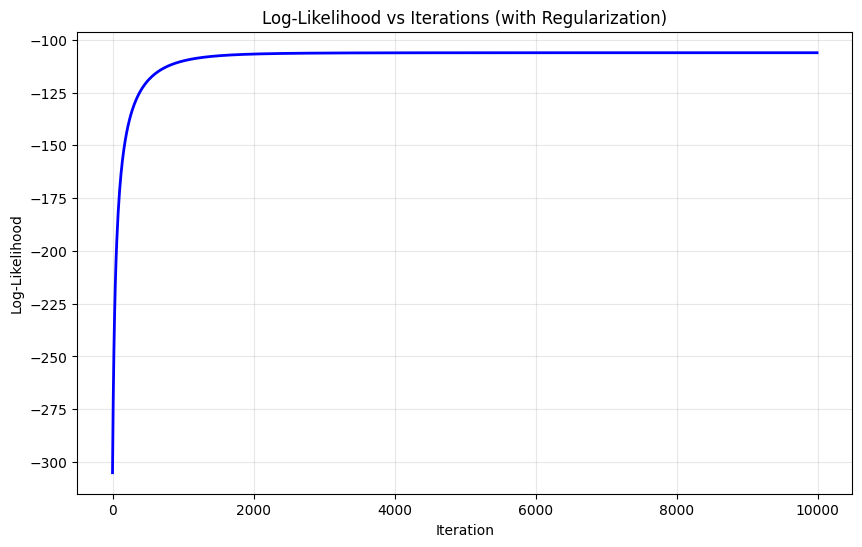

In [273]:
# Plot log-likelihood over iterations
plt.figure(figsize=(10, 6))
iterations = np.arange(0, num_iters, 10)
plt.plot(iterations, log_likelihood_values, 'b-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Iterations (with Regularization)')
plt.grid(True, alpha=0.3)
plt.show()


## Evaluate Model


In [274]:
# Make predictions on all sets
threshold = 0.5

y_train_pred = predict_class(X_train_aug, w, threshold)
y_val_pred = predict_class(X_val_aug, w, threshold)
y_test_pred = predict_class(X_test_aug, w, threshold)

# Get probabilities
y_train_prob = hypothesis(X_train_aug, w)
y_val_prob = hypothesis(X_val_aug, w)
y_test_prob = hypothesis(X_test_aug, w)


In [275]:
# Compute metrics using custom functions
print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)

for name, y_true, y_pred, y_prob in [
    ("Training", y_train, y_train_pred, y_train_prob),
    ("Validation", y_val, y_val_pred, y_val_prob),
    ("Test", y_test, y_test_pred, y_test_prob)
]:
    print(f"\n{name} Set:")
    print("-" * 40)
    
    # Custom precision and recall
    precision, recall = precision_recall(y_pred, y_true, threshold)
    f1 = f1_score(precision, recall)
    
    # Accuracy
    accuracy = np.mean(y_pred.flatten() == y_true.flatten())
    
    # Confusion matrix
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # ROC AUC
    try:
        auc = roc_auc_score(y_true.flatten(), y_prob.flatten())
        print(f"ROC AUC: {auc:.4f}")
    except:
        print("ROC AUC: N/A (single class)")


EVALUATION METRICS

Training Set:
----------------------------------------
Accuracy: 0.9283
Precision: 0.9298
Recall: 0.9375
F1 Score: 0.9336

Confusion Matrix:
[[189  17]
 [ 15 225]]
ROC AUC: 0.9846

Validation Set:
----------------------------------------
Accuracy: 0.8917
Precision: 0.8592
Recall: 0.9531
F1 Score: 0.9037

Confusion Matrix:
[[46 10]
 [ 3 61]]
ROC AUC: 0.9763

Test Set:
----------------------------------------
Accuracy: 0.8167
Precision: 0.7442
Recall: 1.0000
F1 Score: 0.8533

Confusion Matrix:
[[34 22]
 [ 0 64]]
ROC AUC: 0.9713


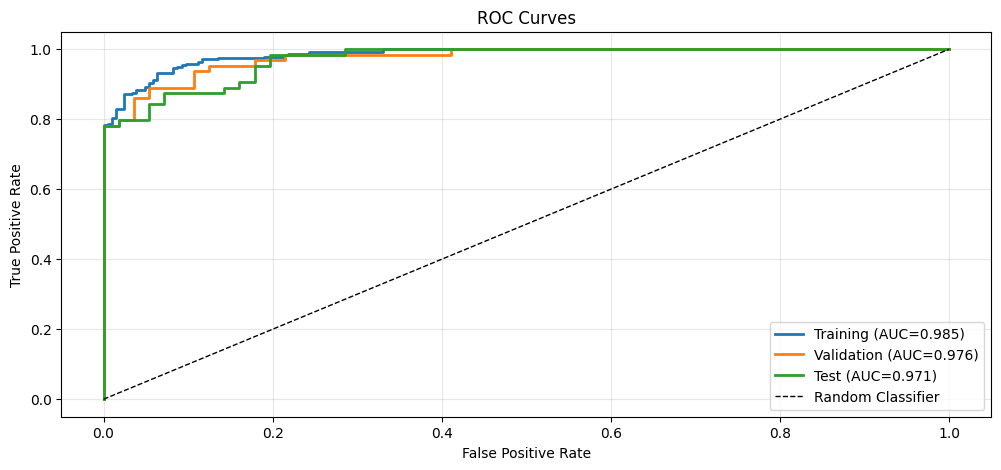

In [276]:
# Plot ROC curves
plt.figure(figsize=(12, 5))

for name, y_true, y_prob in [
    ("Training", y_train, y_train_prob),
    ("Validation", y_val, y_val_prob),
    ("Test", y_test, y_test_prob)
]:
    try:
        fpr, tpr, _ = roc_curve(y_true.flatten(), y_prob.flatten())
        auc = roc_auc_score(y_true.flatten(), y_prob.flatten())
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)
    except:
        pass

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Hyperparameter Tuning


In [277]:
# Try different regularization strengths
lambda_values = [0, 0.01, 0.001, 0.1, 1, 10]
results = []

print("Hyperparameter Tuning: Testing different lambda values")
print("=" * 60)

for lambda_reg in lambda_values:
    # Train with this lambda
    w_tune, _ = Gradient_Ascent(
        X_train_aug, 
        y_train, 
        learning_rate, 
        num_iters, 
        lambda_reg=lambda_reg,
        verbose=False
    )
    
    # Evaluate on validation set
    y_val_pred_tune = predict_class(X_val_aug, w_tune, threshold)
    y_val_prob_tune = hypothesis(X_val_aug, w_tune)
    precision, recall = precision_recall(y_val_pred_tune, y_val, threshold)
    f1 = f1_score(precision, recall)
    accuracy = np.mean(y_val_pred_tune.flatten() == y_val.flatten())
    
    # Calculate AUC
    try:
        auc_val = roc_auc_score(y_val.flatten(), y_val_prob_tune.flatten())
    except:
        auc_val = 0
    
    results.append({
        'lambda': lambda_reg,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_val
    })
    
    print(f"Lambda={lambda_reg:6.3f}: Accuracy={accuracy:.4f}, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, AUC={auc_val:.4f}")

# Find best lambda based on AUC score
results_df = pd.DataFrame(results)
best_idx = results_df['auc'].idxmax()
best_lambda = results_df.loc[best_idx, 'lambda']
best_auc = results_df.loc[best_idx, 'auc']

print(f"\nBest lambda (selected by AUC score): {best_lambda} (AUC={best_auc:.4f})")
print(f"Validation metrics at best lambda:")
print(f"  Accuracy: {results_df.loc[best_idx, 'accuracy']:.4f}")
print(f"  Precision: {results_df.loc[best_idx, 'precision']:.4f}")
print(f"  Recall: {results_df.loc[best_idx, 'recall']:.4f}")
print(f"  F1 Score: {results_df.loc[best_idx, 'f1']:.4f}")
print(f"  AUC: {results_df.loc[best_idx, 'auc']:.4f}")


Hyperparameter Tuning: Testing different lambda values
Lambda= 0.000: Accuracy=0.9000, F1=0.9048, Precision=0.9194, Recall=0.8906, AUC=0.9794
Lambda= 0.010: Accuracy=0.9083, F1=0.9147, Precision=0.9077, Recall=0.9219, AUC=0.9796
Lambda= 0.001: Accuracy=0.8917, F1=0.8976, Precision=0.9048, Recall=0.8906, AUC=0.9796
Lambda= 0.100: Accuracy=0.8917, F1=0.9037, Precision=0.8592, Recall=0.9531, AUC=0.9763
Lambda= 1.000: Accuracy=0.7583, F1=0.8129, Precision=0.6923, Recall=0.9844, AUC=0.9643
Lambda=10.000: Accuracy=0.6000, F1=0.7273, Precision=0.5714, Recall=1.0000, AUC=0.9328

Best lambda (selected by AUC score): 0.01 (AUC=0.9796)
Validation metrics at best lambda:
  Accuracy: 0.9083
  Precision: 0.9077
  Recall: 0.9219
  F1 Score: 0.9147
  AUC: 0.9796


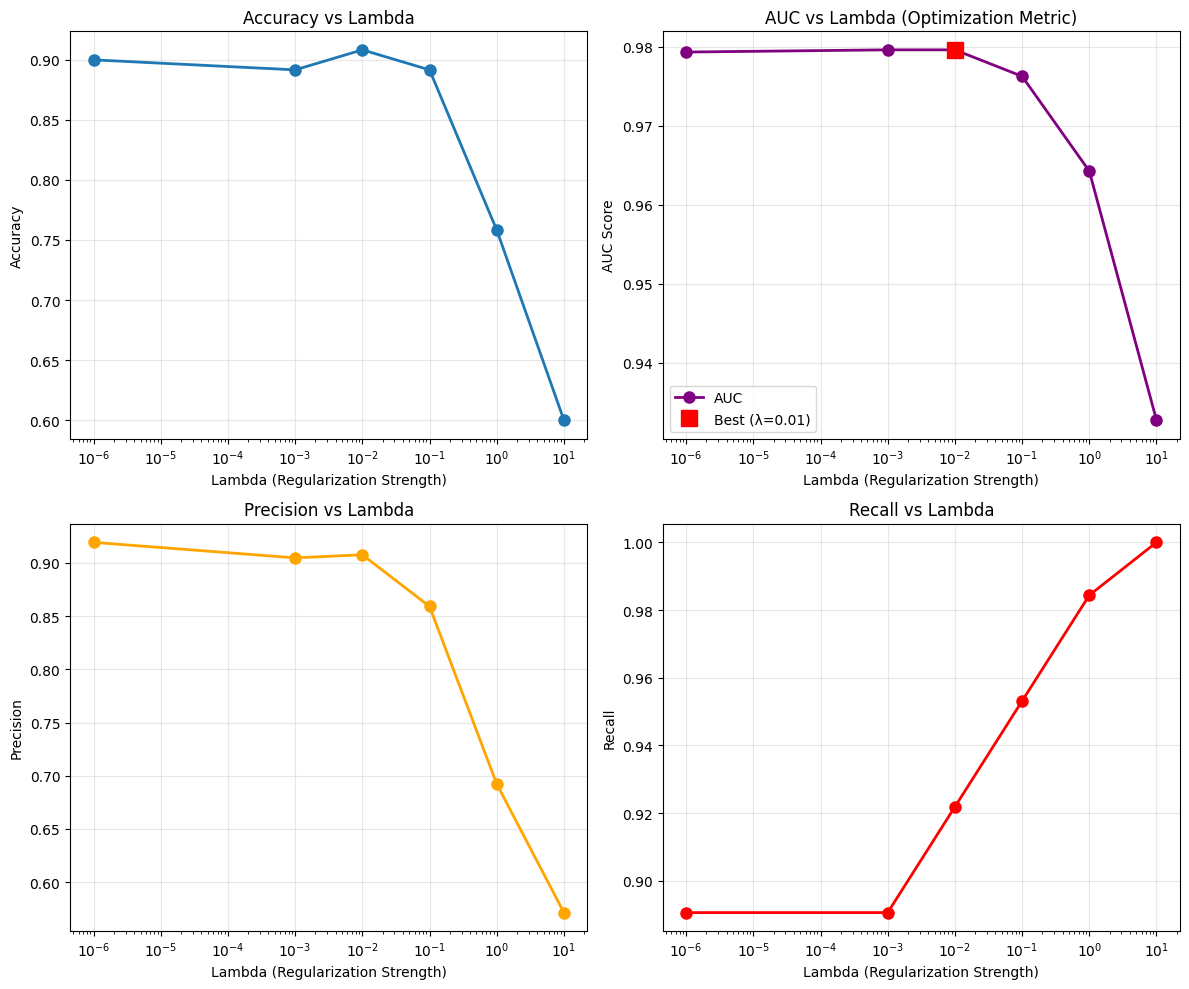

In [278]:
# Plot hyperparameter tuning results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Sort by lambda for proper line plotting
plot_df = results_df.copy()
plot_df['plot_lambda'] = plot_df['lambda'].apply(lambda x: 1e-6 if x == 0 else x)
plot_df = plot_df.sort_values('plot_lambda')

# Find best lambda for highlighting
best_plot_lambda = plot_df[plot_df['lambda'] == best_lambda]['plot_lambda'].values[0]
best_auc_plot = plot_df[plot_df['lambda'] == best_lambda]['auc'].values[0]

axes[0, 0].plot(plot_df['plot_lambda'], plot_df['accuracy'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Lambda (Regularization Strength)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Lambda')
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True, alpha=0.3)

# AUC plot (optimization metric) - highlight best point
axes[0, 1].plot(plot_df['plot_lambda'], plot_df['auc'], 'o-', linewidth=2, markersize=8, color='purple', label='AUC')
axes[0, 1].plot(best_plot_lambda, best_auc_plot, 's', markersize=12, color='red', label=f'Best (λ={best_lambda})', zorder=5)
axes[0, 1].set_xlabel('Lambda (Regularization Strength)')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].set_title('AUC vs Lambda (Optimization Metric)')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].plot(plot_df['plot_lambda'], plot_df['precision'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Lambda (Regularization Strength)')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Lambda')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(plot_df['plot_lambda'], plot_df['recall'], 'o-', linewidth=2, markersize=8, color='red')
axes[1, 1].set_xlabel('Lambda (Regularization Strength)')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall vs Lambda')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Final Model with Best Hyperparameters


In [279]:
# Train final model with best lambda (selected by AUC score on validation set)
print(f"Training final model with best lambda={best_lambda} (AUC={best_auc:.4f} on validation)")
w_final, _ = Gradient_Ascent(
    X_train_aug, 
    y_train, 
    learning_rate, 
    num_iters, 
    lambda_reg=best_lambda,
    verbose=False
)

# Evaluate on test set
y_test_pred_final = predict_class(X_test_aug, w_final, threshold)
y_test_prob_final = hypothesis(X_test_aug, w_final)

precision, recall = precision_recall(y_test_pred_final, y_test, threshold)
f1 = f1_score(precision, recall)
accuracy = np.mean(y_test_pred_final.flatten() == y_test.flatten())

# Calculate AUC
try:
    test_auc = roc_auc_score(y_test.flatten(), y_test_prob_final.flatten())
except:
    test_auc = 0

print("\nFinal Test Set Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {test_auc:.4f}")

cm = confusion_matrix(y_test.flatten(), y_test_pred_final.flatten())
print(f"\nConfusion Matrix:")
print(cm)


Training final model with best lambda=0.01 (AUC=0.9796 on validation)

Final Test Set Results:
Accuracy: 0.8833
Precision: 0.8205
Recall: 1.0000
F1 Score: 0.9014
AUC: 0.9738

Confusion Matrix:
[[42 14]
 [ 0 64]]


In [280]:
print("\n" + "=" * 80)
print("DETAILED RESULTS: All Lambda Values (Validation Set)")
print("=" * 80)
print(results_df[['lambda', 'accuracy', 'auc', 'f1', 'precision', 'recall']].to_string(index=False))

print("\n" + "=" * 80)
print("PERFORMANCE BY LAMBDA")
print("=" * 80)
lambda_stats = results_df.groupby('lambda').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'auc': ['mean', 'std', 'min', 'max'],
    'f1': ['mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std', 'min', 'max'],
    'recall': ['mean', 'std', 'min', 'max']
}).round(4)
print(lambda_stats)


DETAILED RESULTS: All Lambda Values (Validation Set)
 lambda  accuracy      auc       f1  precision   recall
  0.000  0.900000 0.979353 0.904762   0.919355 0.890625
  0.010  0.908333 0.979632 0.914729   0.907692 0.921875
  0.001  0.891667 0.979632 0.897638   0.904762 0.890625
  0.100  0.891667 0.976283 0.903704   0.859155 0.953125
  1.000  0.758333 0.964286 0.812903   0.692308 0.984375
 10.000  0.600000 0.932757 0.727273   0.571429 1.000000

PERFORMANCE BY LAMBDA
       accuracy                         auc                          f1      \
           mean std     min     max    mean std     min     max    mean std   
lambda                                                                        
0.000    0.9000 NaN  0.9000  0.9000  0.9794 NaN  0.9794  0.9794  0.9048 NaN   
0.001    0.8917 NaN  0.8917  0.8917  0.9796 NaN  0.9796  0.9796  0.8976 NaN   
0.010    0.9083 NaN  0.9083  0.9083  0.9796 NaN  0.9796  0.9796  0.9147 NaN   
0.100    0.8917 NaN  0.8917  0.8917  0.9763 NaN  0.9763  